In [1]:
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython import display
from sklearn import datasets, preprocessing
import tensorflow as tf

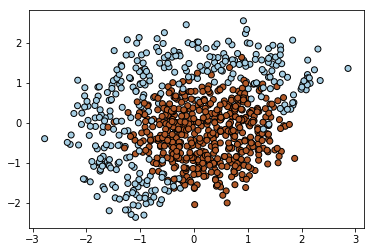

In [2]:
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = np.logical_or(y==1, X[:,1] > X[:,0] - 0.5)
X = X[ind,:]
X = preprocessing.scale(X)
y = y[ind]
y = 2*y - 1
X, y = X.astype(np.float32), y.astype(np.float32)
plt.scatter(X[:, 0], X[:, 1], cmap=plt.cm.Paired, c=y, edgecolors='black')
plt.show()

In [3]:
X.shape, y.shape

((838, 2), (838,))

In [4]:
h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


def visualize(X, y, w, loss, n_iter):
    plt.clf()
    plt.figure(figsize=(20, 8))
    Z = classify(np.c_[xx.ravel(), yy.ravel()], w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())

**Your task starts here**

First, let's write a function that predicts class for given X.

Since the problem above isn't linearly separable, we add quadratic features to the classifier. This transformation is implemented in the __expand__ function.

__Don't forget to expand X inside classify and other functions__

Sample classification should not be much harder than computation of sign of dot product.

In [5]:
def expand(X):
    """
    Given feature matrix X[n_samples, 2], expand it to X[n_samples, 6],
    adding some quadratic features.
    """
    X0 = tf.transpose(tf.gather(tf.transpose(X), [0]))
    X1 = tf.transpose(tf.gather(tf.transpose(X), [1]))
    ones = tf.reshape(tf.ones_like(X0), [-1, 1])
    return tf.concat([X, X ** 2, X0 * X1, ones], axis=1)


def classify(X, w):
    """
    Given feature matrix X[n_samples, 2] and weight vector w[6],
    return an array of +1 or -1 predictions
    """
    X = expand(X)
    y = tf.squeeze(X @ w[:, np.newaxis])
    out = tf.where(y == 0, tf.ones_like(y), tf.sign(y))
    with tf.Session() as sess:
        return sess.run(out)

The loss you should try to minimize is the Hinge Loss:

$$ L =  {1 \over N} \sum_{i=1}^N max(0,1-y_i \cdot  w^T x_i) $$



In [6]:
def compute_loss(X, y, w):
    """
    Given feature matrix X[n_samples, 2], target vector[n_samples] of +1/-1,
    and weight vector w[6], compute scalar loss function using formula above.
    """
    X = expand(X)
    z = 1 - y * tf.squeeze((X @ tf.reshape(w, [-1, 1])))
    return tf.reduce_mean(tf.where(z >= 0, z, tf.zeros_like(z)))


def compute_grad(X, y, w):
    """
    Given feature matrix X[n_samples, 2], target vector[n_samples] of +1/-1,
    and weight vector w[6], compute vector[6] of derivatives of L over each weights.
    """
    X = expand(X)
    z = 1 - y * tf.squeeze((X @ tf.reshape(w, [-1, 1])))
    mask = tf.where(z >= 0, tf.ones_like(z), tf.zeros_like(z))
    return tf.reduce_mean(tf.reshape(-mask * y, [-1, 1]) * X, axis=0)

Common things for all algos:

In [7]:
X_in = tf.placeholder(tf.float32, shape=[None, X.shape[1]], name="X")
y_in = tf.placeholder(tf.float32, shape=[None], name="y")
w_in = tf.placeholder(tf.float32, shape=[6], name="w")
loss_out = compute_loss(X_in, y_in, w_in)
grad_out = compute_grad(X_in, y_in, w_in)

### Training

You can see the example of correct output below this cell before you run it.

**Don't change the batch size!**

In [8]:
batch_size = 4
n_iter = 50

Find an optimal learning rate for gradient descent for given batch size. 

In [9]:
alpha = 0.25
w_out = w_in - alpha * grad_out

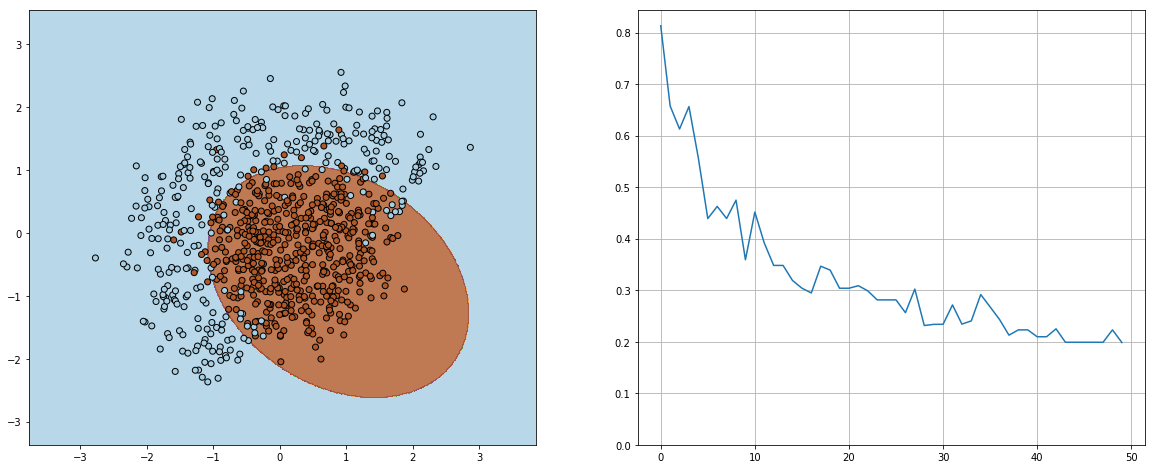

In [10]:
w = np.array([1, 0, 0, 0, 0, 0], dtype=np.float32)

loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))
with tf.Session() as sess:
    for i in range(n_iter):
        loss[i] = sess.run(loss_out, feed_dict={X_in: X, y_in: y, w_in: w})
        ind = random.sample(range(X.shape[0]), batch_size)
        w = sess.run(w_out, feed_dict={X_in: X[ind, :], y_in: y[ind], w_in: w})

visualize(X, y, w, loss, n_iter)
plt.clf()

Implement gradient descent with momentum and test it's performance for different learning rate and momentum values.

In [11]:
alpha = 0.25
mu = 0.4
v_in = tf.placeholder(tf.float32, shape=[6], name="v")
v_out = mu * v_in - alpha * grad_out
w_out = w_in + v_out

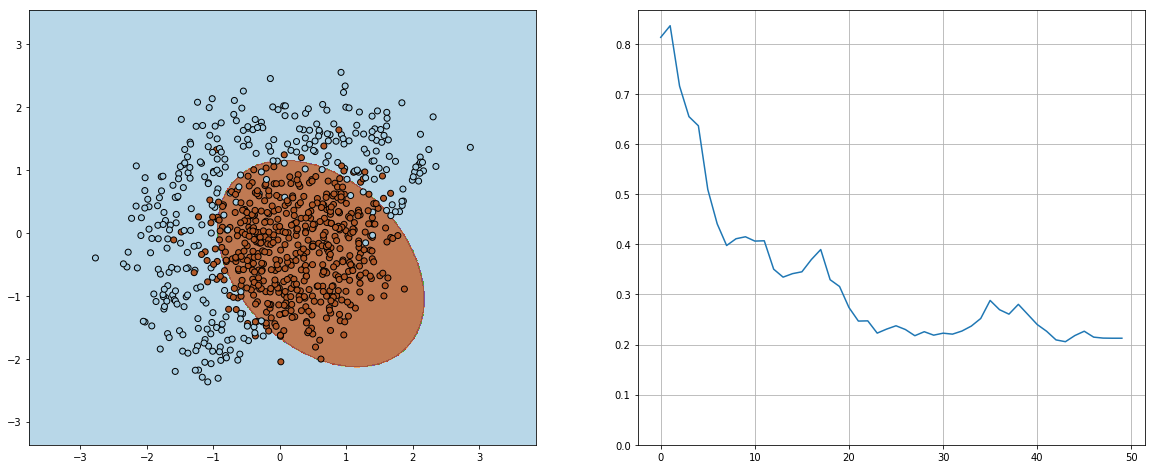

In [12]:
w = np.array([1, 0, 0, 0, 0, 0], dtype=np.float32)
v = np.zeros(6, dtype=np.float32)

loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    for i in range(n_iter):
        loss[i] = sess.run(loss_out, feed_dict={X_in: X, y_in: y, w_in: w})
        ind = random.sample(range(X.shape[0]), batch_size)
        v, w = sess.run([v_out, w_out], feed_dict={X_in: X[ind, :], y_in: y[ind], 
                                                   w_in: w, v_in: v})

visualize(X, y, w, loss, n_iter)
plt.clf()

Same task but for Nesterov's accelerated gradient:

In [13]:
alpha = 0.25
mu = 0.4
w_imp = w_in + mu * v_in
grad_imp = compute_grad(X_in, y_in, w_imp)
v_out = mu * v_in - alpha * grad_imp
w_out = w_in + v_out

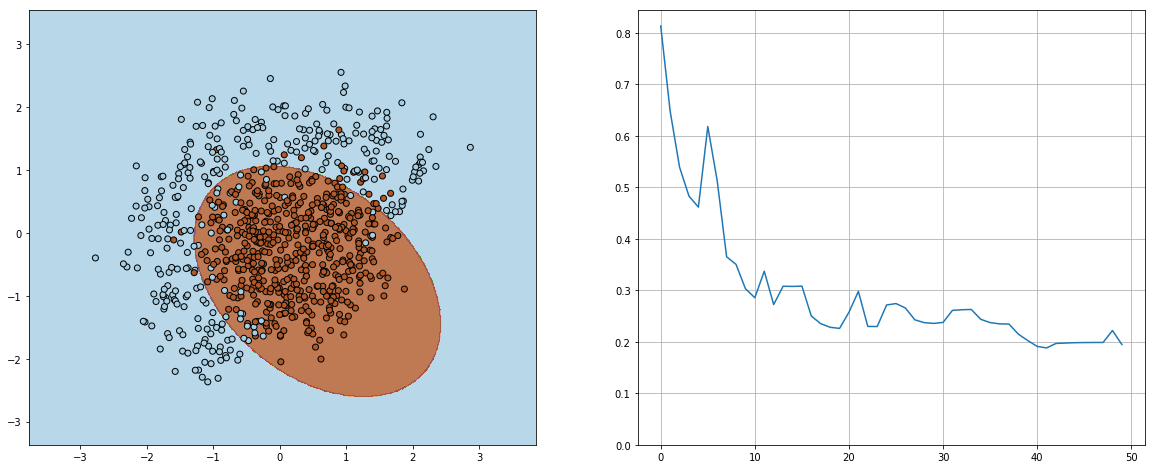

In [14]:
w = np.array([1, 0, 0, 0, 0, 0], dtype=np.float32)
v = np.zeros(6, dtype=np.float32)

loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        loss[i] = sess.run(loss_out, feed_dict={X_in: X, y_in: y, w_in: w})
        v, w = sess.run([v_out, w_out], feed_dict={X_in: X[ind, :], y_in: y[ind], 
                                                   w_in: w, v_in: v})

visualize(X, y, w, loss, n_iter)
plt.clf()

Same task but for AdaGrad:

In [15]:
alpha = 0.3
eps = 1e-8
c_in = tf.placeholder(tf.float32, shape=[6], name="c")
c_out = c_in + (grad_out ** 2)
w_out = w_in - (alpha / (tf.sqrt(c_out) + eps)) * grad_out

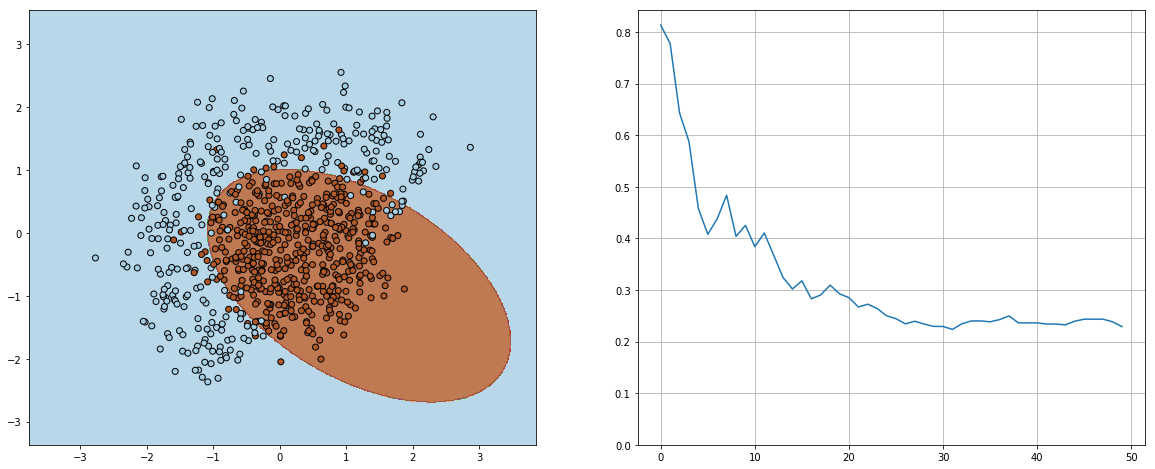

In [16]:
w = np.array([1, 0, 0, 0, 0, 0], dtype=np.float32)
c = np.zeros(6, dtype=np.float32)

loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    for i in range(n_iter):
        loss[i] = sess.run(loss_out, feed_dict={X_in: X, y_in: y, w_in: w})
        ind = random.sample(range(X.shape[0]), batch_size)
        c, w = sess.run([c_out, w_out], feed_dict={X_in: X[ind, :], y_in: y[ind], 
                                                   w_in: w, c_in: c})

visualize(X, y, w, loss, n_iter)
plt.clf()

Same task but for AdaDelta:

In [17]:
alpha = 0.1
beta = 0.9
eps = 1e-8
c_out = beta * c_in + (1 - beta) * (grad_out ** 2)
w_out = w_in - (alpha / (tf.sqrt(c_out) + eps)) * grad_out

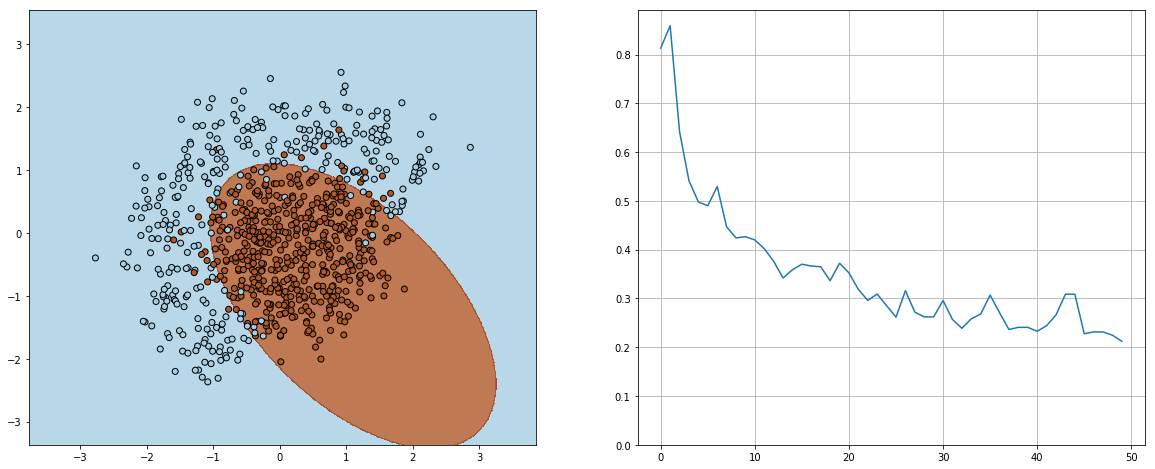

In [18]:
w = np.array([1, 0, 0, 0, 0, 0], dtype=np.float32)
c = np.zeros(6, dtype=np.float32)

loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    for i in range(n_iter):
        loss[i] = sess.run(loss_out, feed_dict={X_in: X, y_in: y, w_in: w})
        ind = random.sample(range(X.shape[0]), batch_size)
        c, w = sess.run([c_out, w_out], feed_dict={X_in: X[ind, :], y_in: y[ind], 
                                                   w_in: w, c_in: c})

visualize(X, y, w, loss, n_iter)
plt.clf()

Same task for Adam algorithm. You can start with beta = 0.9 and mu = 0.999

In [19]:
alpha = 0.1
beta = 0.8
mu = 0.7
eps = 1e-8
v_out = mu * v_in + (1 - mu) * grad_out
c_out = beta * c_in + (1 - beta) * (grad_out ** 2)
w_out = w_in - (alpha / (tf.sqrt(c_out) + eps)) * v_out

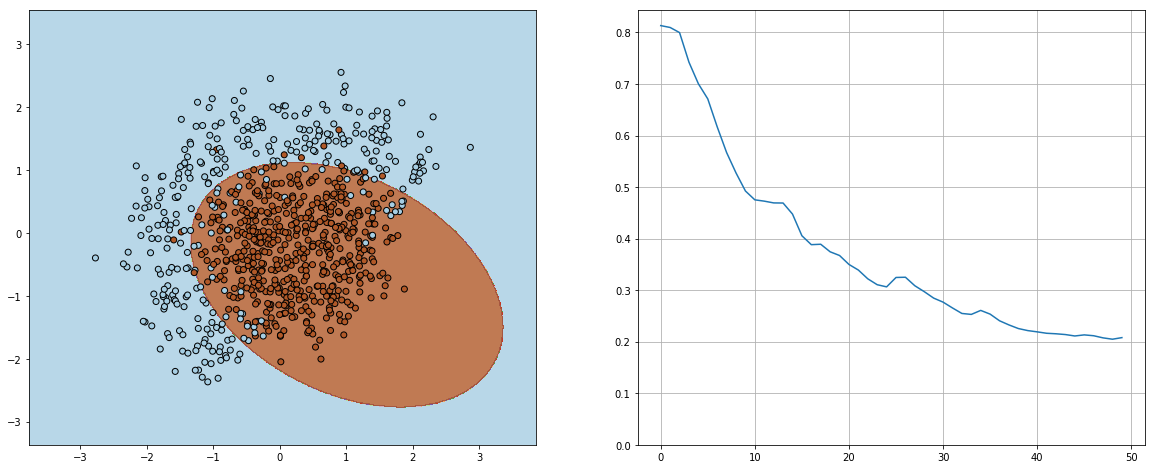

In [20]:
w = np.array([1, 0, 0, 0, 0, 0], dtype=np.float32)
v = np.zeros(6, dtype=np.float32)
c = np.zeros(6, dtype=np.float32)

loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    for i in range(n_iter):
        loss[i] = sess.run(loss_out, feed_dict={X_in: X, y_in: y, w_in: w})
        ind = random.sample(range(X.shape[0]), batch_size)
        v, c, w = sess.run([v_out, c_out, w_out], feed_dict={X_in: X[ind, :], 
                                                             y_in: y[ind], w_in: w, 
                                                             v_in: v, c_in: c})

visualize(X, y, w, loss, n_iter)
plt.clf()